<h2> Mount Drive & Define Working Directory </h2>

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
working_dir = '/content/drive/MyDrive/gdp'
os.chdir(working_dir)

<h2> Clone AlphaPose (Just Once) </h2>

In [ ]:
import os
!git clone https://github.com/MVIG-SJTU/AlphaPose.git

<h2> Install AlphaPose Dependencies & Build (Just Once) </h2>

In [ ]:
! pip install pyyaml==5.2
! pip install scipy==1.1.0
! pip install torch==1.2.0 torchvision==0.4.0
! pip install pillow==6.2.2
! pip install csaps
! pip install tensorflow==2.8.0
import torch
print(torch.__version__)
import yaml, scipy
print(yaml.__version__)
print(scipy.__version__)

!python -m pip install cython
!sudo apt-get install libyaml-dev

os.chdir(f'{working_dir}/AlphaPose')
print(os.getcwd())
! python setup.py build develop

<h2> Additional AlphaPose Files (Just Once) </h2>

In [6]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists(f'{working_dir}/AlphaPose/detector/yolo/data'):
  os.makedirs(f'{working_dir}/AlphaPose/detector/yolo/data')

if not os.path.exists(f'{working_dir}/AlphaPose/detector/tracker/data'):
  os.makedirs(f'{working_dir}/AlphaPose/detector/tracker/data')

file_id = '1D47msNOOiJKvPOXlnpyzdKA3k6E97NTC'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(f'{working_dir}/AlphaPose/detector/yolo/data/yolov3-spp.weights')

file_id = '1nlnuYfGNuHWZztQHXwVZSL_FvfE551pA'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(f'{working_dir}/AlphaPose/detector/tracker/data/JDE-1088x608-uncertainty')

file_id = '1kQhnMRURFiy7NsdS8EFL-8vtqEXOgECn'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(f'{working_dir}/AlphaPose/pretrained_models/fast_res50_256x192.pth')

<h2> Run Inference on Video </h2>

**PEGA SYSTEM STEPS:**
1. Get video, do inference and get Alphapose json data file.
2. Separate subjects from the json file and do keypoint extraction.
3. Create json files for every frame of every subject.
4. Obtain the required gait frames for every subject.
5. Create the gait signature.
6. Predict normal/abnormal using gait signature.
7. If abnormal extract image frame and apply ReID.



<h3> Functions </h3>

In [7]:
# Functions
import os
import subprocess
import json
import pandas as pd
import numpy as np
import glob
import math
from scipy import signal
from scipy.signal import find_peaks
import csaps
from sklearn.preprocessing import MinMaxScaler

def alphapose_inference(input_video, output_folder):
  command = f'python3 scripts/demo_inference.py --cfg configs/coco/resnet/256x192_res50_lr1e-3_1x.yaml --checkpoint pretrained_models/fast_res50_256x192.pth --video {input_video} --pose_track --posebatch 256 --outdir {output_folder} --save_video --vis_fast'
  alphapose_cmd = subprocess.Popen(command, shell=True)
  alphapose_cmd.wait()

  new_file_name = input_video.replace('mp4','json')
  os.rename(f'{output_folder}/alphapose-results.json', f'{output_folder}/{new_file_name}')
  return alphapose_cmd.returncode

def keypoint_extractor(json_file, output_folder):
  json_file = json.load(open(json_file))
  json_df = pd.DataFrame(json_file)
  reid_list = json_df.idx.unique()

   # Create folder if does not exist
  if not os.path.exists(output_folder):
      os.makedirs(output_folder)

  for id in reid_list:
    # Analyse each subject from the json file
    subject = json_df[json_df['idx']==id].reset_index(drop=True)

    # Check to have at least 25 frames for each subject
    if len(subject) < 25:
      continue

    # Loop frames and extract keypoints
    for i in range(0, len(subject)):
        # Reorder keypoints Alphapose -> OpenPose and split each subject
        keypoints = subject['keypoints'][i]
        nose = [keypoints[0], keypoints[1], keypoints[2]]
        left_eye = [keypoints[3], keypoints[4], keypoints[5]]
        right_eye = [keypoints[6], keypoints[7], keypoints[8]]
        left_ear = [keypoints[9], keypoints[10], keypoints[11]]
        right_ear = [keypoints[12], keypoints[13], keypoints[14]]
        left_shoulder = [keypoints[15], keypoints[16], keypoints[17]]
        right_shoulder = [keypoints[18], keypoints[19], keypoints[20]]
        left_elbow = [keypoints[21], keypoints[22], keypoints[23]]
        right_elbow = [keypoints[24], keypoints[25], keypoints[26]]
        left_hand = [keypoints[27], keypoints[28], keypoints[29]]
        right_hand = [keypoints[30], keypoints[31], keypoints[32]]
        left_hip = [keypoints[33], keypoints[34], keypoints[35]]
        right_hip = [keypoints[36], keypoints[37], keypoints[38]] 
        left_knee = [keypoints[39], keypoints[40], keypoints[41]]
        right_knee = [keypoints[42], keypoints[43], keypoints[44]]
        left_ankle = [keypoints[45], keypoints[46], keypoints[47]]
        right_ankle = [keypoints[48], keypoints[49], keypoints[50]]
        neck = (np.array(left_shoulder)+np.array(right_shoulder))/2

        # Check only people going towards the camera
        # if right_hand_xpos > left_hand_xpos skip to next iteration
        if keypoints[30] > keypoints[27]:
          continue

        # Create keypoints in Open Pose format (for compatibility)
        keypoints = nose + neck.tolist() + right_shoulder + right_elbow + right_hand + left_shoulder + left_elbow + left_hand + right_hip + right_knee + right_ankle + left_hip + left_knee + left_ankle + right_eye + left_eye + right_ear + left_ear
        alphapose_dict = {'people': [{'pose_keypoints_2d': keypoints}]}

        # Create sub folder to save json files
        save_sub_folder = f'{output_folder}/{str(id).zfill(5)}'
        if not os.path.exists(save_sub_folder):
            os.makedirs(save_sub_folder)

        # Save dictionary as json
        image_frame = subject['image_id'][i].replace('.jpg', '').zfill(6)
        filename = f'{str(id).zfill(3)}_{image_frame}'
        out_file = open(f'{save_sub_folder}/{filename}.json', 'w')
        json.dump(alphapose_dict, out_file)
        out_file.close()

def frame_extraction(input_folder):
  json_list = sorted(glob.glob(f'{input_folder}/*.json'))

  knees = []
  for subject in json_list:
      subject_dict = json.load(open(subject))

      data = subject_dict['people'][0]['pose_keypoints_2d']
      x = data[0:len(data):3]
      x = [float('nan') if i==0 else i for i in x]

      y = data[1:len(data):3]
      y = [ -z for z in y]
      y = [float('nan') if i==0 else i for i in y]

      right_knee = np.array([x[9], y[9]])
      left_knee = np.array([x[12], y[12]])

      neck = np.array([x[1], y[1]])
      hip_center = (np.array([x[8], y[8]]) + np.array([x[11], y[11]]))/2

      dist_neck_hip = math.hypot(neck[0]-hip_center[0], neck[1]-hip_center[1])

      knee = math.hypot(right_knee[0]-left_knee[0], right_knee[1]-left_knee[1])
      knees.append(knee/dist_neck_hip)

  # Get peaks
  knees = signal.detrend(knees)
  t = np.linspace(0.0, len(knees)-1, len(knees))

  fft_peaks = find_peaks(knees, height=0, distance = 25)
  fft_heights = fft_peaks[1]['peak_heights']
  fft_heights_xpos = fft_peaks[0]

  sorted_fft_heights = fft_heights[np.argsort(-fft_heights)]
  sorted_fft_heights_positions = fft_heights_xpos[np.argsort(-fft_heights)]

  peaks = []
  for i in range(0,len(sorted_fft_heights)):
      max_freq = t[sorted_fft_heights_positions[i]]
      max_freq_height = sorted_fft_heights[i]
      peaks.append([max_freq, max_freq_height])

  peaks = sorted(peaks)

  # Get distances between peaks
  peak_distances = []
  for j in range(0, len(peaks)-1):
      pkdist = math.sqrt((peaks[j][0]-peaks[j+1][0])**2 + (peaks[j][1]-peaks[j+1][1])**2)
      peak_distances.append(pkdist)

  min_index = np.argmin(np.abs(peak_distances - np.mean(peak_distances)))

  return int(peaks[min_index][0]), int(peaks[min_index+1][0])

def dist(a, b):
  x0 = a[0]
  y0 = a[1]
  x1 = b[0]
  y1 = b[1]
  return np.sqrt((x0-x1)**2+(y0-y1)**2)

def getAngle(p1, p2, p3):
  d_line = np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
  d_knee = dist(p2, p3)
  return math.degrees(math.asin(d_line/d_knee))

def vectorAngle(vector1, vector2):
  x1, y1 = vector1
  x2, y2 = vector2
  inner_product = x1*x2 + y1*y2
  len1 = math.hypot(x1, y1)
  len2 = math.hypot(x2, y2)
  return math.degrees(math.acos(inner_product/(len1*len2)))

def gait_signature(input_folder, start_frame, end_frame):
  json_list = sorted(glob.glob(f'{input_folder}/*.json'))
  json_list_2 = json_list[start_frame:end_frame]
  right_leg = True

  primary_knee_angles = []
  secondary_knee_angles = []
  primary_hip_angles = []
  secondary_hip_angles = []
  torso_angles = []

  for body in json_list_2:
      person_dict = json.load(open(body))

      data = person_dict['people'][0]['pose_keypoints_2d']
      x = data[0:len(data):3]
      x = [float('nan') if i==0 else i for i in x]

      y = data[1:len(data):3]
      y = [ -z for z in y]
      y = [float('nan') if i==0 else i for i in y]
    
      right_shoulder = np.array([x[2], y[2]])
      right_hip_top = np.array([x[8], 0])
      right_hip = np.array([x[8], y[8]])
      right_knee = np.array([x[9], y[9]])
      right_ankle = np.array([x[10], y[10]])

      left_shoulder = np.array([x[5], y[5]])
      left_hip_top = np.array([x[11], 0])
      left_hip = np.array([x[11], y[11]])
      left_knee = np.array([x[12], y[12]])
      left_ankle = np.array([x[13], y[13]])

      vector1 = (right_shoulder-left_shoulder)/np.linalg.norm(right_shoulder-left_shoulder)
      vector2 = (right_hip-left_hip)/np.linalg.norm(right_hip-left_hip)

      right_knee_angle = getAngle(right_hip, right_knee, right_ankle)
      left_knee_angle = getAngle(left_hip, left_knee, left_ankle)

      right_hip_angle = getAngle(right_knee, right_hip, right_hip_top)
      left_hip_angle = getAngle(left_knee, left_hip, left_hip_top)

      torso_angle = vectorAngle(vector1, vector2)

      if right_leg == True:
          primary_knee_angle = right_knee_angle
          primary_hip_angle = right_hip_angle
          secondary_knee_angle = left_knee_angle
          secondary_hip_angle = left_hip_angle
      else:
          primary_knee_angle = left_knee_angle
          primary_hip_angle = left_hip_angle
          secondary_knee_angle = right_knee_angle
          secondary_hip_angle = right_hip_angle

      primary_knee_angles.append(primary_knee_angle)
      secondary_knee_angles.append(secondary_knee_angle)

      primary_hip_angles.append(primary_hip_angle)
      secondary_hip_angles.append(secondary_hip_angle)

  # Primary knee angle
  t = np.linspace(0, len(primary_knee_angles), len(primary_knee_angles))
  t2 = np.linspace(0, len(primary_knee_angles), 100)
  sp = csaps.CubicSmoothingSpline(t, primary_knee_angles, smooth=0.5)
  primary_knee_spline = sp(t2)

  # Secondary knee angle
  t = np.linspace(0, len(secondary_knee_angles), len(secondary_knee_angles))
  t2 = np.linspace(0, len(secondary_knee_angles), 100)
  sp = csaps.CubicSmoothingSpline(t, secondary_knee_angles, smooth=0.5)
  secondary_knee_spline = sp(t2)

  # Primary hip angle
  t = np.linspace(0, len(primary_hip_angles), len(primary_hip_angles))
  t2 = np.linspace(0, len(primary_hip_angles), 100)
  sp = csaps.CubicSmoothingSpline(t, primary_hip_angles, smooth=0.5)
  primary_hip_spline = sp(t2)

  # Secondary hip angle
  t = np.linspace(0, len(secondary_hip_angles), len(secondary_hip_angles))
  t2 = np.linspace(0, len(secondary_hip_angles), 100)
  sp = csaps.CubicSmoothingSpline(t, secondary_hip_angles, smooth=0.5)
  secondary_hip_spline = sp(t2)

  gait_array = np.column_stack((primary_knee_spline, secondary_knee_spline, 
                          primary_hip_spline, secondary_hip_spline))

  gait_array_one_column = gait_array.reshape([-1,1])

  scaler = MinMaxScaler()
  scaler.fit(gait_array_one_column)
  gait_array_minmax = scaler.transform(gait_array_one_column).reshape(gait_array.shape)

  return gait_array_minmax
      

<h3> Main Routine </h3>

Analysing: dummy_injured.mp4
Alphapose successfully analysed video!


Frame Extraction:   0%|          | 0/1 [00:00<?, ?it/s]


Prediction: [[0.9999895]]


Frame Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


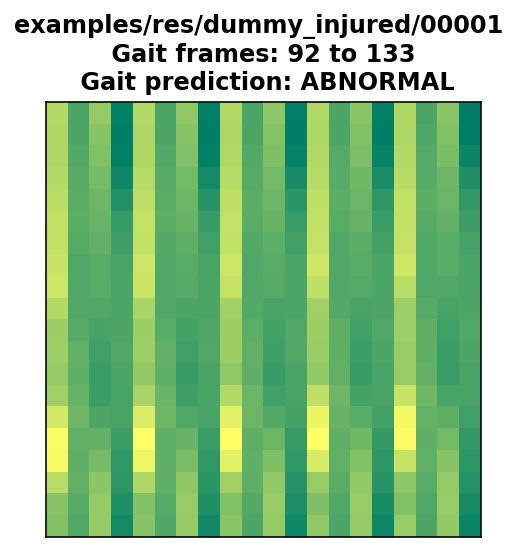

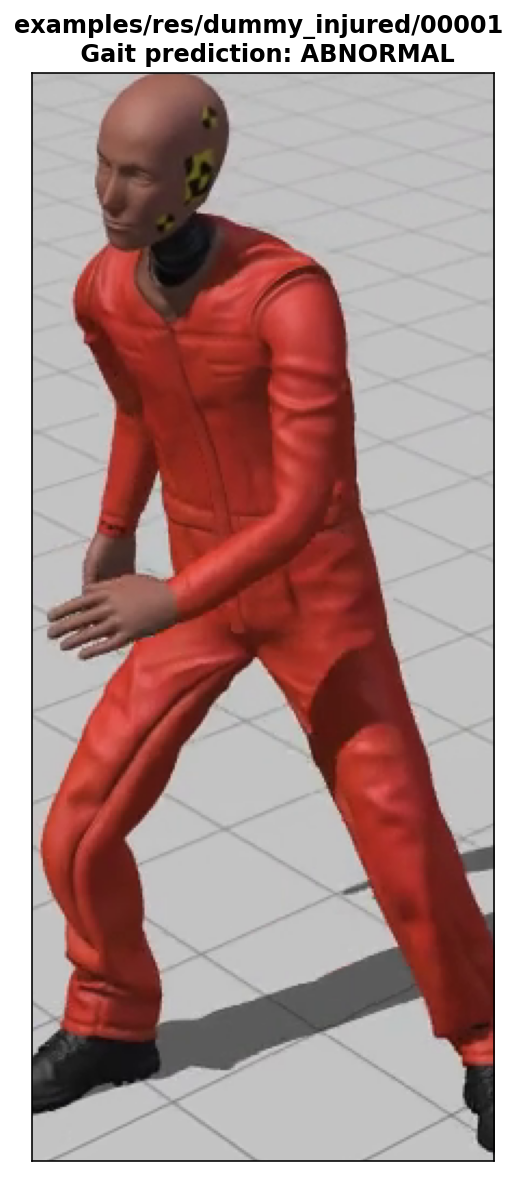

In [15]:
# Alphapose Pose Estimation
# Change working folder
import glob
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import joblib
import cv2 
from google.colab.patches import cv2_imshow
%matplotlib inline
%config InlineBackend.figure_format='retina'
os.chdir(f'{working_dir}/AlphaPose')

video_list = ['dummy_injured.mp4']
output_folder = 'examples/res'

for video_path in video_list:
  print(f'Analysing: {video_path}')
  #----------------------------------
  # STEP 1
  #----------------------------------

  inference = alphapose_inference(video_path, output_folder)

  if inference == 0:
    print(f'Alphapose successfully analysed video!')
  else:
    print(f'Alphapose had an error analysing the video!')

  #----------------------------------
  # STEP 2 & 3
  #----------------------------------

  # Process json data
  json_name = video_path.replace('mp4', 'json')
  json_file = f'{output_folder}/{json_name}'

  output_name = video_path.replace('.mp4', '')
  keypoint_folder = f'{output_folder}/{output_name}'

  keypoint_extractor(json_file, keypoint_folder)

  # Remove folders with less than 25 frames
  keypoint_folders = sorted(glob.glob(f'{keypoint_folder}/*'))
  for kfolder in tqdm(keypoint_folders, desc = 'Folder Removal'):
    nfiles = len(sorted(glob.glob(f'{kfolder}/*.*')))
    if nfiles < 25:
      shutil.rmtree(kfolder)

  #----------------------------------
  # STEP 4
  #----------------------------------
  keypoint_folders = sorted(glob.glob(f'{keypoint_folder}/*'))

  for kfolder in tqdm(keypoint_folders, desc = 'Frame Extraction'):
    try:
      frame_start, frame_end = frame_extraction(kfolder)
    except:
      print('No gait found')

    #----------------------------------
    # STEP 5
    #----------------------------------
    gait_array = gait_signature(kfolder, frame_start, frame_end)
    np.save(f'{kfolder}/gait', gait_array) # Save npy array

    #----------------------------------
    # STEP 6
    #----------------------------------
    model = keras.models.load_model('model_220322.h5')
    predict = model.predict(gait_array.reshape(-1, 20, 20, 1))
    print(f'\nPrediction: {predict}')
    
    if predict >= .5:
      status = 'ABNORMAL'
    else:
      status = 'NORMAL'

    fig, ax = plt.subplots()
    ax.imshow(gait_array.reshape(20,20), cmap='summer')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'{kfolder} \n Gait frames: {frame_start} to {frame_end} \n Gait prediction: {status}', fontweight='bold')

    #----------------------------------
    # STEP 7
    #----------------------------------

    if status == 'ABNORMAL':
      json_dataframe = pd.DataFrame(json.load(open(json_file)))
      subject = json_dataframe[json_dataframe['idx']==int(kfolder.split('/')[-1])].reset_index(drop=True)
      x,y,w,h = list(map(int, subject['box'][frame_start]))
      cap = cv2.VideoCapture(video_list[0])
      cap.set(cv2.CAP_PROP_POS_FRAMES, frame_start) # optional
      success, img = cap.read()
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      fig2, ax2 = plt.subplots(figsize=(5,10))
      ax2.imshow(img[y:y+h, x:x+w])
      ax2.get_xaxis().set_visible(False)
      ax2.get_yaxis().set_visible(False)
      ax2.set_title(f'{kfolder} \n Gait prediction: {status}', fontweight='bold')
    